In [1]:
import pandas as pd

In [2]:
from pybaseball import batting_stats, batting_stats_bref

In [3]:
statcast = pd.read_csv("../statcastdata.csv")

In [4]:
statcast = statcast.loc[(statcast["game_date"] < "2019-01-01") & (statcast["game_date"] > "2018-01-01")]

In [5]:
b = batting_stats(2018)

In [6]:
def get_pca5_series_pitcher(df):
    pab = df.groupby(["pitcher", "game_date", "batter", "inning"]).size()
    return pab.loc[pab > 5].to_frame().reset_index().groupby("pitcher").size()

In [7]:
def get_pca5_series_batter(df):
    bab = df.groupby(["batter", "game_date", "inning"]).size()
    return bab.loc[bab > 5].to_frame().reset_index().groupby("batter").size()

In [8]:
def get_bf(df):
    return df.loc[df["events"].notna()].groupby(["pitcher"]).size()

In [9]:
# returns tuple (release_speed_mean, effective_speed_mean, pfx_x_mean, pfx_z_mean)
def get_movement_series(df):
    d = df.groupby("pitcher").agg({"release_speed": "mean",
                                 "effective_speed": "mean",
                                 "pfx_x": "mean", 
                                 "pfx_z": "mean"}).abs().rename(index=str, columns={"release_speed": "release_speed_mean",
                                                                 "effective_speed": "effective_speed_mean",
                                                                 "pfx_x": "pfx_x_mean",
                                                                 "pfx_z": "pfx_z_mean"})
    return (d["release_speed_mean"], d["effective_speed_mean"], d["pfx_x_mean"], d["pfx_z_mean"])

In [10]:
def get_event_series_pitcher(df, event):
    return df.loc[(df["events"] == event)].groupby("pitcher").size()

def get_event_series_batter(df, event):
    return df.loc[(df["events"] == event)].groupby("batter").size()

In [11]:
# this only estimates ip, it is not perfect
def get_ip_series(df):
    return df.groupby(["pitcher", "game_date"])["inning"].nunique().to_frame().reset_index().groupby("pitcher")["inning"].sum()

In [12]:
def get_whip_series(df):
    walks = df.loc[(df["events"] == "walk")].groupby("pitcher").size()
    hits = df.loc[(df["events"] == "single") |
                        (df["events"] == "double") |
                        (df["events"] == "triple") |
                        (df["events"] == "home_run")].groupby("pitcher").size()
    stuff = pd.concat([get_ip_series(df), walks, hits], keys=["ip", "walks", "hits"], axis=1)
    return (stuff["walks"] + stuff["hits"]) / stuff["ip"]

In [13]:
def remove_infreq_pitchers(df):
    bf = get_bf(df)
    bf.loc[bf > 70].index

    return df.loc[(df["pitcher"].isin(bf.loc[bf > 70].index))]

def make_pitcher_df(df):
    df = remove_infreq_pitchers(df)
    _, avg_speed, avg_x, avg_z = get_movement_series(df)
    return pd.concat([get_event_series_pitcher(df, "strikeout"),
                      get_event_series_pitcher(df, "home_run"),
                      get_event_series_pitcher(df, "walk"), # I don't think we can do IBB
                      get_pca5_series_pitcher(df),
                      get_bf(df),
                      get_whip_series(df),
                      avg_speed,
                      avg_x,
                      avg_z
                     ],
                     keys=["SO", "HR", "BB", "PCA5", "BF", "WHIP", "avg_speed", "avg_x", "avg_z"],
                     axis=1)

def make_efp_series(pitcher_df):
    df = pitcher_df
    # WE DON'T HAVE IBB, only BB
    return (1.0*df["SO"] - (0.5*df["PCA5"] + 3.0*df["HR"] + 3.0*df["BB"])) / df["BF"] - \
            1.0*df["WHIP"] + 0.1*df["avg_z"] + 0.1*df["avg_x"] + 0.3*df["avg_speed"]

In [14]:
from pybaseball.playerid_lookup import get_lookup_table
lookup_table = get_lookup_table()

def playerid_lookup_c(last, first=None, year=None):
    # force input strings to lowercase
    last = last.lower()
    if first:
        first = first.lower()
    table = lookup_table
    
    if first is None:
        if year is not None:
            results = table.loc[(table['name_last'] == last) &
                                (table['mlb_played_first'] <= year) &
                                (table['mlb_played_last'] >= year)]
        else:
            results = table.loc[table['name_last'] == last]
    else:
        if year is not None:
            results = table.loc[(table['name_last'] == last) & (table['name_first'] == first) &
                                (table['mlb_played_first'] <= year) &
                                (table['mlb_played_last'] >= year)]
        else:
            results = results = table.loc[(table['name_last'] == last) & (table['name_first'] == first)]

        iterations = 0
        while len(results) == 0 and iterations < 10:
            iterations += 1
            if 'jr.' in last:
                last = last.replace('jr.', '').strip()
            elif 'jr' in last:
                last = last.replace('jr', '').strip()
            elif '.' in first and ' ' in first:
                first = first.replace(' ', '').replace('.', '')
            elif '.' in first:
                first = first[:first.index('.') + 1] + ' ' + first[first.index('.') + 1:]
            elif first == 'nicholas':
                first = 'nick'
            elif first == 'yolmer' and last == 'sanchez':
                first = 'carlos'
            elif first == 'raffy' and last == 'lopez':
                first = 'rafael'
            elif last == 'ervin':
                first = 'phil'
            elif last == 'wheeler' and first == 'zack':
                first = 'zach'
            elif last == 'joyce' and first == 'matt':
                first = 'matthew'
            elif last == 'vogelbach' and first == 'daniel':
                first = 'dan'
            elif last == 'kang':
                first = 'jung ho'
            elif last == 'urshela':
                first = 'gio'
            elif last == 'poncedeleon':
                last = 'ponce de leon'
            elif last == 'bowman' and first == 'matt':
                first = 'matthew'
            elif last == 'chargois':
                first = 'j. t.'
            elif last == 'boyd' and first == 'matthew':
                first = 'matt'
            elif last == 'gosselin' and first == 'phil':
                first = 'philip'
            elif last == 'guerra' and first == 'javier':
                first = 'javy'
            elif last == 'delmonico' and first == 'nicky':
                first = 'nick'
            elif last == 'wilkerson' and first == 'steve':
                first = 'stevie'
            elif first == 'john' and last == 'ryan murphy':
                first = 'j. r.'
                last = 'murphy'
            else:
                for name_bit in last.split(' '):
                    if len(name_bit) <= 3:
                        last = last.replace(name_bit, '').strip()

            if year is not None:
                results = table.loc[(table['name_last'] == last) & (table['name_first'] == first) &
                                    (table['mlb_played_first'] <= year) &
                                    (table['mlb_played_last'] >= year)]
            else:
                results = results = table.loc[(table['name_last'] == last) &
                                              (table['name_first'] == first)]
    
    
    #results[['key_mlbam', 'key_fangraphs', 'mlb_played_first', 'mlb_played_last']] = results[['key_mlbam', 'key_fangraphs', 'mlb_played_first', 'mlb_played_last']].astype(int) # originally returned as floats which is wrong
    results = results.reset_index().drop('index', 1)
    return results

def get_mlbam_from_name(last, first=None, year=None):
    try:
        return playerid_lookup_c(last, first, year=year).dropna().reset_index(drop=True)["key_mlbam"].iloc[0]
    except IndexError as e:
        if '.' in first and ' ' in first:
            first = first.replace(' ', '').replace('.', '')
        elif '.' in first:
            first = first[:first.index('.') + 1] + ' ' + first[first.index('.') + 1:]
        elif first.lower() == 'nicholas':
            first = 'nick'
        elif first.lower() == 'yolmer' and last.lower() == 'sanchez':
            first = 'carlos'
        else:
            #raise Exception("your name bad: %s, %s" % (last, first))
            print("bad name: %s, %s" % (last, first))
            return -1
        
        return get_mlbam_from_name(last, first)
        return playerid_lookup_c(last, first).dropna().reset_index(drop=True)["key_mlbam"].iloc[0]
        # j.d. martinez -> j. d. martinez

def add_mlbam_to_fg(df_fg):
    def get_last_first(name):
        s = name.split(' ')
        last, first = ' '.join(s[1:]), s[0]
        return last, first
    
    def get_mlbam(name):
        last, first = get_last_first(name)
        return get_mlbam_from_name(last, first)
    
    df_fg["key_mlbam"] = df_fg["Name"].apply(get_mlbam)
    return df_fg

Gathering player lookup table. This may take a moment.


In [15]:
def remove_infreq_batters(df_fangraphs):
    return df_fangraphs.loc[(df_fangraphs["AB"] > 50)]

def make_batter_df(df_fangraphs, df_statcast):
    df_fg = remove_infreq_batters(df_fangraphs).copy()
    df_fg = add_mlbam_to_fg(df_fg)
    pca5 = get_pca5_series_batter(df_statcast).rename("PCA5")
    df_fg = df_fg.merge(pca5.to_frame(), left_on="key_mlbam", right_on="batter")
    df_fg = df_fg.set_index("key_mlbam")
    return df_fg

def make_efb_series(batter_df):
    df = batter_df
    return (((1.0 * df["HR"] + 0.8*df["3B"] + 0.5*df["2B"] + 0.2*df["1B"] + 0.5*df["SB"] - \
           (0.4*df["SO"] + 0.2*df["BB"] + 0.2*df["PCA5"])) / df["PA"]) + 2) * 10

In [16]:
make_efb_series(make_batter_df(b, statcast)).sort_values(ascending=False)

key_mlbam
553902    20.680412
643446    20.370968
606299    20.272328
592743    20.270000
516416    20.226266
645302    20.212121
488726    20.209192
578428    20.193966
605141    20.171010
493329    20.167539
501571    20.156250
609280    20.150165
609275    20.147766
543829    20.130952
544369    20.110721
572816    20.084428
649557    20.064159
592518    20.063470
596019    20.063087
435559    20.056701
435062    20.056250
502517    20.051282
516782    20.044554
593160    20.005658
596748    20.000000
405395    19.997992
592696    19.994932
456488    19.988048
527038    19.983683
514888    19.983306
            ...    
595284    18.590698
592230    18.564516
605233    18.558140
592680    18.556250
593934    18.555184
452657    18.553846
571945    18.549296
518774    18.526316
592791    18.523810
572204    18.510949
446481    18.508671
448801    18.498084
571578    18.492537
621433    18.442177
547379    18.419048
607257    18.384615
488771    18.337838
488671    18.196581
592685    

In [17]:
from pybaseball import playerid_lookup, playerid_reverse_lookup

In [18]:
playerid_reverse_lookup([606299], key_type="mlbam")

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,peraza,jose,606299,peraj003,perazjo01,13593,2015.0,2019.0


In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
efb_series = make_efb_series(make_batter_df(b, statcast)).sort_values(ascending=False)

In [35]:
def graph_excitingness(series,playerId):
    n, bins, patches = plt.hist(series, bins=100, align='right', color='g')
    new_bins = np.round(bins,decimals=3)
    #print(np.round(efb_series[efb_series.keys()[0]],decimals=2))
    #print(np.where(new_bins == np.round(efb_series[efb_series.keys()[0]],decimals=2))[0][0])
    try:
        value = np.round(series[playerId],decimals=2)
        #print(np.where((new_bins >= value-0.5) & (new_bins <= value+0.5))[0])
        patch_list = np.where((new_bins >= value-0.05) & (new_bins <= value+0.05))[0]-1
        for i in patch_list:
            patches[i].set_fc('r')
        plt.show()
    except Exception:
        print("Invalid key, or queringing the wrong series")

20.68
100
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100]


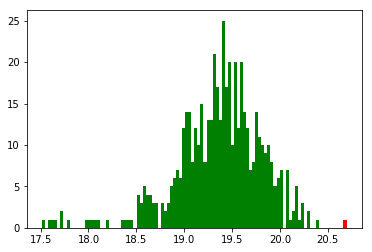

In [22]:
n, bins, patches = plt.hist(efb_series, bins=100, align='right', color='g')
new_bins = np.round(bins,decimals=3)
print(np.round(efb_series[efb_series.keys()[0]],decimals=2))
print(np.where(new_bins == np.round(efb_series[efb_series.keys()[0]],decimals=2))[0][0])
value = np.round(efb_series[efb_series.keys()[0]],decimals=2)
print(np.where((new_bins >= value-0.5) & (new_bins <= value+0.5))[0])
patch_list = np.where((new_bins >= value-0.1) & (new_bins <= value+0.1))[0]-1
for i in patch_list:
    patches[i].set_fc('r')
plt.show()

In [24]:
efp_series = make_efp_series(make_pitcher_df(statcast)).sort_values(ascending=False)

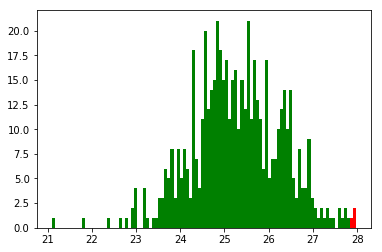

In [26]:
n, bins, patches = plt.hist(efp_series, bins=100, align='right', color='g')
new_bins = np.round(bins,decimals=3)
#print(np.round(efb_series[efb_series.keys()[0]],decimals=2))
#print(np.where(new_bins == np.round(efb_series[efb_series.keys()[0]],decimals=2))[0][0])
value = np.round(efp_series[efp_series.keys()[0]],decimals=2)
#print(np.where((new_bins >= value-0.5) & (new_bins <= value+0.5))[0])
patch_list = np.where((new_bins >= value-0.1) & (new_bins <= value+0.1))[0]-1
for i in patch_list:
    patches[i].set_fc('r')
plt.show()

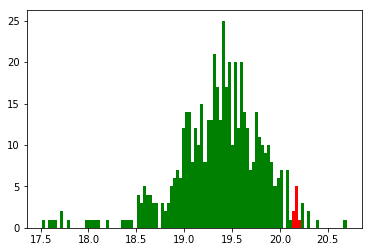

In [37]:
graph_excitingness(efb_series,501571)